In [1]:
#!/usr/bin/env python

# Ideal_DisplacementBasedEvaluation.ipynb

In [1]:
''' 
   Ideal_DisplacementBasedEvaluation.ipynb

   Here we test the performacne of the program on ideal test cases.
   
   Those are ellipses with different displacement and shape errors. 
   Only spatial displacements are tested.

'''

' \n   Ideal_DisplacementBasedEvaluation.ipynb\n\n   Here we test the performacne of the program on ideal test cases.\n   \n   Those are ellipses with different displacement and shape errors. \n   Only spatial displacements are tested.\n\n'

In [126]:
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
from datetime import timedelta
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import shapefile as shp
import matplotlib.path as mplPath

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [455]:
# from https://stochasticcoder.com/2016/04/06/python-custom-distance-radius-with-basemap/
def createCircleAroundWithRadius(lat, lon, radiusMiles):
    ring = ogr.Geometry(ogr.wkbLinearRing)
    latArray = []
    lonArray = []

    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng,radiusMiles)
        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray,latArray


def getLocation(lat1, lon1, brng, distanceMiles):
    lat1 = lat1 * math.pi/ 180.0
    lon1 = lon1 * math.pi / 180.0
    #earth radius
    R = 6378.1 #Km
    #R = ~ 3959 MilesR = 3959

    distanceMiles = distanceMiles/R

    brng = (brng / 90)* math.pi / 2

    lat2 = math.asin(math.sin(lat1) * math.cos(distanceMiles) 
    + math.cos(lat1) * math.sin(distanceMiles) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(distanceMiles)
    * math.cos(lat1),math.cos(distanceMiles)-math.sin(lat1)*math.sin(lat2))

    lon2 = 180.0 * lon2/ math.pi
    lat2 = 180.0 * lat2/ math.pi

    return lat2, lon2

def Normalize(DATA):
    NORM = (DATA - np.nanmean(DATA))/np.nanstd(DATA)
    return NORM

###  USER MODIFY SECTION

In [502]:
#  location of SGP site
ARMlon = -97.4882
ARMlat = 36.6077

# --------------------------------
# Settings for displacement search
TempDicpl = 2 # +- search window in hours arround time of peak dBZ observatio
SpatialDispl = 7 # +- search windown in degrees for spatial displacement

sPlotDir = '/glade/u/home/prein/papers/2021_ASR_Optimal_Location/plots/Ideal_Cases/'

### Create an idealized grid that we use for the tests

In [529]:
LLC_Lat = 20
LLC_Lon = -125
URC_Lat = 55
URC_Lon = -55
dx = 0.1
Lon = np.arange(LLC_Lon,URC_Lon, dx)
Lat = np.arange(LLC_Lat,URC_Lat, dx)[::-1]
Lon, Lat = np.meshgrid(Lon,Lat)
rgrGridCells=np.array([(Lon.ravel()[ii],Lat.ravel()[ii]) for ii in range(len(Lon.ravel()))])


### Create test ellipse

In [540]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from matplotlib.patches import PathPatch

CASES = ['location bias\n4$^{\circ}$ to the east', 
         'amplitude bias\n4$^{\circ}$ to the east & 10 dBZ stronger', 
         'shape bias\n5$^{\circ}$ to the east & twice as wide', 
         'orientation bias\n7$^{\circ}$ to the east & 90$^{\circ}$ rotated']
Mask=np.zeros((2,Lon.shape[0]*Lon.shape[1],len(CASES)))

for ca in range(2):  # work on location and amplitude bias
    for da in range(Mask.shape[0]):
        if da == 0:
            dLon = 0
            bias = 0
        else:
            dLon = 4
            if ca == 0:
                bias = 0
            elif ca == 1:
                bias = 10

        # ----- Large Elipse -----
        # Create the base ellipse
        ellipse = Ellipse((ARMlon+dLon, ARMlat), width=3, height=8,
                          edgecolor='white', facecolor='none', linewidth=2)
        # Get the path
        path = ellipse.get_path()
        # Get the list of path vertices
        vertices = path.vertices.copy()
        # Transform the vertices so that they have the correct coordinates
        vertices = ellipse.get_patch_transform().transform(vertices)
        # plt.scatter(vertices[:,0],vertices[:,1])
        ctr=np.array(vertices)
        region=mplPath.Path(ctr)
        TMP=np.array(region.contains_points(rgrGridCells))
        Mask[da,TMP == 1,ca]=30+bias

        # ----- Add 3 Small Ellipses -----
        Lat3 = [ARMlat+2, ARMlat, ARMlat-2]
        for ii in range(3):
            ellipse = Ellipse((ARMlon+0.7+dLon, Lat3[ii]), width=0.5, height=1,
                          edgecolor='white', facecolor='none', linewidth=2)
            path = ellipse.get_path()
            vertices = path.vertices.copy()
            vertices = ellipse.get_patch_transform().transform(vertices)
            ctr=np.array(vertices)
            region=mplPath.Path(ctr)
            TMP=np.array(region.contains_points(rgrGridCells))
            Mask[da,TMP == 1,ca]= 60+bias
            
# -------- WORK ON SHAPE BIAS CASE -----------          
ca = 2
for da in range(Mask.shape[0]):
    if da == 0:
        dLon = 0
        LonWidh = 1
        dLonSmall = 0.7
    else:
        dLon = 5
        LonWidh = 2
        dLonSmall = 1.5

    # ----- Large Elipse -----
    # Create the base ellipse
    ellipse = Ellipse((ARMlon+dLon, ARMlat), width=3*LonWidh, height=8,
                      edgecolor='white', facecolor='none', linewidth=2)
    # Get the path
    path = ellipse.get_path()
    # Get the list of path vertices
    vertices = path.vertices.copy()
    # Transform the vertices so that they have the correct coordinates
    vertices = ellipse.get_patch_transform().transform(vertices)
    ctr=np.array(vertices)
    region=mplPath.Path(ctr)
    TMP=np.array(region.contains_points(rgrGridCells))
    Mask[da,TMP == 1,ca]=30

    # ----- Add 3 Small Ellipses -----
    Lat3 = [ARMlat+2, ARMlat, ARMlat-2]
    for ii in range(3):
        ellipse = Ellipse((ARMlon+dLonSmall+dLon, Lat3[ii]), width=0.5*LonWidh, height=1,
                      edgecolor='white', facecolor='none', linewidth=2)
        path = ellipse.get_path()
        vertices = path.vertices.copy()
        vertices = ellipse.get_patch_transform().transform(vertices)
        ctr=np.array(vertices)
        region=mplPath.Path(ctr)
        TMP=np.array(region.contains_points(rgrGridCells))
        Mask[da,TMP == 1,ca]= 60

        

# -------- WORK ON ROTATION BIAS CASE -----------          
ca = 3
for da in range(Mask.shape[0]):
    if da == 0:
        dLon = 0
        WIDTH = 3
        HEIGHT = 8
        HEIGHT
        LonWidh = 1
    else:
        dLon = 7
        WIDTH = 5
        HEIGHT = 3
        LonWidh = 2
        
    dLonSmall = 0.7

    # ----- Large Elipse -----
    # Create the base ellipse
    ellipse = Ellipse((ARMlon+dLon, ARMlat), width=WIDTH*LonWidh, height=HEIGHT,
                      edgecolor='white', facecolor='none', linewidth=2)
    # Get the path
    path = ellipse.get_path()
    # Get the list of path vertices
    vertices = path.vertices.copy()
    # Transform the vertices so that they have the correct coordinates
    vertices = ellipse.get_patch_transform().transform(vertices)
    ctr=np.array(vertices)
    region=mplPath.Path(ctr)
    TMP=np.array(region.contains_points(rgrGridCells))
    Mask[da,TMP == 1,ca]=30

    if da == 0:
        # ----- Add 3 Small Ellipses -----
        Lat3 = [ARMlat+2, ARMlat, ARMlat-2]
        for ii in range(3):
            ellipse = Ellipse((ARMlon+dLonSmall+dLon, Lat3[ii]), width=0.5*LonWidh, height=1,
                          edgecolor='white', facecolor='none', linewidth=2)
            path = ellipse.get_path()
            vertices = path.vertices.copy()
            vertices = ellipse.get_patch_transform().transform(vertices)
            ctr=np.array(vertices)
            region=mplPath.Path(ctr)
            TMP=np.array(region.contains_points(rgrGridCells))
            Mask[da,TMP == 1,ca]= 60
    else:
        # ----- Add 3 Small Ellipses -----
        Lon3 = [ARMlon+2, ARMlon, ARMlon-2]
        for ii in range(3):
            ellipse = Ellipse((Lon3[ii]+dLon, ARMlat-0.7), width=1, height=0.5,
                          edgecolor='white', facecolor='none', linewidth=2)
            path = ellipse.get_path()
            vertices = path.vertices.copy()
            vertices = ellipse.get_patch_transform().transform(vertices)
            ctr=np.array(vertices)
            region=mplPath.Path(ctr)
            TMP=np.array(region.contains_points(rgrGridCells))
            Mask[da,TMP == 1,ca]= 60

            
Mask=np.reshape(Mask, (2,Lat.shape[0], Lat.shape[1],4))

In [531]:
# cut out hypothetical radar observation
DeltaDeg = 4.4 # degrees
Lat_LLC = np.round(ARMlat,1) - DeltaDeg/2
Lon_LLC = np.round(ARMlon,1) - DeltaDeg/2
Lat_URC = np.round(ARMlat,1) + DeltaDeg/2
Lon_URC = np.round(ARMlon,1) + DeltaDeg/2

NN = np.argmin(np.abs(Lat[:,0] - Lat_URC))
EE = np.argmin(np.abs(Lon[0,:] - Lon_URC))+1
SS = np.argmin(np.abs(Lat[:,0] - Lat_LLC))+1
WW = np.argmin(np.abs(Lon[0,:] - Lon_LLC))

LatA = Lat[NN:SS,WW:EE]
LonA = Lon[NN:SS,WW:EE]
RADAR = Mask[0,NN:SS,WW:EE]
dRad = int(LatA.shape[0]/2)

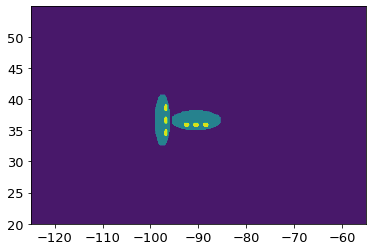

In [532]:
plt.contourf(Lon, Lat, np.sum(Mask[:,:,:,3],axis=0))

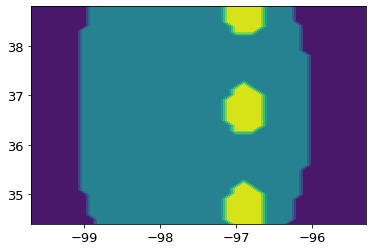

In [533]:
plt.contourf(LonA,LatA,ARM_dBZ[:,:])

## WORK ON DBZ COMPARISON

In [536]:
# GET ARM reference dBZ
DDeg=0 #1.1
NA = np.max(LatA)+DDeg
SA = np.min(LatA)-DDeg
WA = np.min(LonA)-DDeg
EA = np.max(LonA)+DDeg

iN = np.where((Lat[:,0] - NA) < 0)[0][0]
iS = np.where((Lat[:,0] - SA) < 0)[0][0]+1
iW = np.where((Lon[0,:] - WA) > 0)[0][0]
iE = np.where((Lon[0,:] - EA) > 0)[0][0]+1

CC_displacement = np.zeros((WRF_dBZ.shape[0], Length, Length,len(CASES))); CC_displacement[:] = np.nan
CC_displacement_full = np.zeros((WRF_dBZ.shape[0], Lon.shape[0], Lon.shape[1],len(CASES))); CC_displacement_full[:] = np.nan
CDF_reldiff = np.copy(CC_displacement)
CDF_reldiff_full = np.copy(CC_displacement_full)

for ca in range(len(CASES)):
    print('    work on '+CASES[ca])
    ARM_dBZ = Mask[0,iN:iS,iW:iE,ca]
    FIN = ~np.isnan(ARM_dBZ)
    SortObs = np.sort(ARM_dBZ.flatten())
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))
#     SortObs = NormalizeData(SortObs)

    # Cout out area of th WRF simulation that we will compare
    NA = np.max(LatA)+SpatialDispl+DDeg
    SA = np.min(LatA)-SpatialDispl-DDeg
    WA = np.min(LonA)-SpatialDispl-DDeg
    EA = np.max(LonA)+SpatialDispl+DDeg

    iNc = np.where((Lat[:,0] - NA) < 0)[0][0]
    iSc = np.where((Lat[:,0] - SA) < 0)[0][0]
    iWc = np.where((Lon[0,:] - WA) > 0)[0][0]
    iEc = np.where((Lon[0,:] - EA) > 0)[0][0]
    WRF_dBZ = np.copy(Mask[1,iNc:iSc,iWc:iEc,ca][None,:,:])
    WRF_dBZ[np.isnan(WRF_dBZ)] = 0

    # ------- CALCULATE DISPLACEMENT STATISTICS --------
    Bound = int((ARM_dBZ.shape[0]-1)/2)
    WidthY = ARM_dBZ.shape[0]
    WidthX = ARM_dBZ.shape[1]
    Length = int(WRF_dBZ.shape[1] - np.max([WidthX,WidthY]))

    for tt in range(WRF_dBZ.shape[0]):
        for la in range(CC_displacement.shape[1]):
            for lo in range(CC_displacement.shape[2]):
                if np.nanmean(WRF_dBZ[tt,:,:]) != 0:
                    WRF_AREA = WRF_dBZ[tt,la:la+WidthY, lo:lo+WidthX]
                    CC_displacement[tt,la,lo,ca] = scipy.stats.spearmanr(WRF_AREA[FIN].flatten(),ARM_dBZ[FIN].flatten())[0]
                    CC_displacement_full[tt,la+iNc+dRad-1,lo+iWc+dRad-1,ca] = CC_displacement[tt,la,lo,ca]
                    SortMod = np.sort(WRF_AREA.flatten())
                    CDF_reldiff[tt,la,lo,ca] = np.mean(np.abs(SortMod-SortObs))
                    CDF_reldiff_full[tt,la+iNc+dRad-1,lo+iWc+dRad-1,ca] = CDF_reldiff[tt,la,lo,ca]

    work on location bias
    work on amplitude bias
    work on shape bias
    work on orientation bias


### Plot the displacement metric

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/u/home/prein/papers/2021_ASR_Optimal_Location/plots/Ideal_Cases/IdealTests.pdf


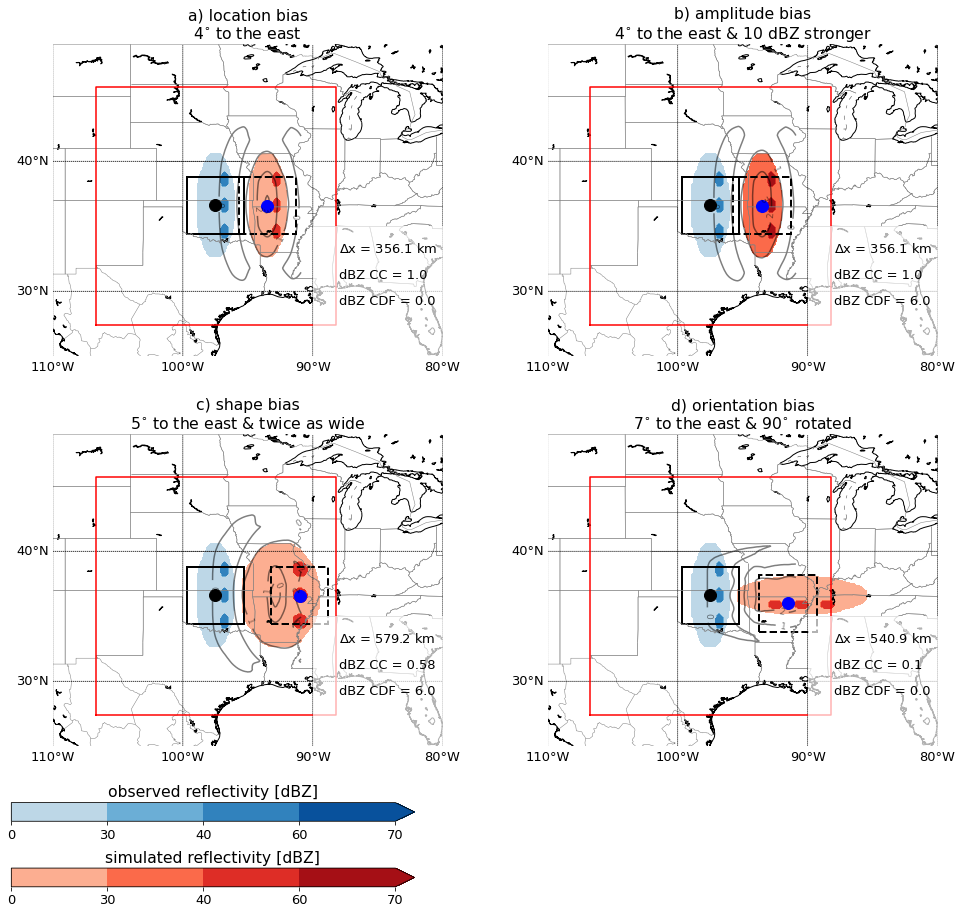

In [545]:
import string
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from osgeo import ogr, osr
import math
from matplotlib.patches import Polygon

plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)
# cmap = mpl.cm.get_cmap('coolwarm')

fig = plt.figure(figsize=(14,13))

# plot the BT and dBZ maps first
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.08, right=0.98,
bottom=0.2, top=0.95,
wspace=0.20, hspace=0.25)

XX = [0,1,0,1]
YY = [0,0,1,1]
for ca in range(len(CASES)):
    # displacement matrix
    dBZ_CDF_norm = np.abs(Normalize(CDF_reldiff_full[:,:,:,ca]))
    dBZ_CC_norm = Normalize(CC_displacement_full[:,:,:,ca])
    dBZ_displaccement = np.nanmean(np.array([dBZ_CDF_norm, dBZ_CC_norm]), axis=0)

    Displacement = dBZ_displaccement

    iMAX = np.argmax(np.nanmax(Displacement, axis=(1,2)))
    MIN = np.where(Displacement[iMAX,:,:] == np.nanmax(Displacement[iMAX,:,:]))
    iLatMIN = MIN[0][0] #iARM[0][0]+MIN[0][0]-int(Displacement.shape[1]/2)
    iLonMIN = MIN[1][0] #iARM[1][0]+MIN[1][0]-int(Displacement.shape[2]/2)
    LatMIN = Lat[iLatMIN,iLonMIN]
    LonMIN = Lon[iLatMIN,iLonMIN]
    
    #---- start plotting
    ax = plt.subplot(gs1[YY[ca],XX[ca]])
    m = Basemap(llcrnrlon=-110,llcrnrlat=25,urcrnrlon=-80,urcrnrlat=49,
            projection='cyl',lat_1=33,lat_2=40,lon_0=-95, resolution='i')
    plt.axis('off')
    xi, yi = m(Lon, Lat)

    TestData = np.copy(Mask[0,:,:,ca])
    TestData[TestData == 0] = np.nan
    csO = m.contourf(xi,yi,TestData, levels=[0,30,40,60,70], extend='max',colors=['#bdd7e7','#6baed6','#3182bd','#08519c'])

    TestData = np.copy(Mask[1,:,:,ca])
    TestData[TestData == 0] = np.nan
    csS = m.contourf(xi,yi,TestData, levels=[0,30,40,60,70], extend='max',colors=['#fcae91','#fb6a4a','#de2d26','#a50f15'])
    
    # plot the displacement matrix as contours
    CS = m.contour(xi,yi,Displacement[iMAX,:,:], colors='k', levels=np.linspace(0,10, 11), alpha=0.5)
    ax.clabel(CS, fontsize=9, inline=True, fmt='%1.0f')

    # plot the ARM site
    xi,yi = m(ARMlon,ARMlat)
    m.plot(xi,yi, 'ko', markersize=12)
    # plot radar reach around ARM site
    x1,y1 = m(ARMlon-DeltaDeg/2,ARMlat-DeltaDeg/2)
    x2,y2 = m(ARMlon+DeltaDeg/2,ARMlat-DeltaDeg/2)
    x3,y3 = m(ARMlon+DeltaDeg/2,ARMlat+DeltaDeg/2)
    x4,y4 = m(ARMlon-DeltaDeg/2,ARMlat+DeltaDeg/2)
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='None',edgecolor='k',linewidth=2)
    plt.gca().add_patch(poly)


    
    # draw coastlines and political boundaries.
    m.drawcoastlines()
    m.drawcountries(color='gray')
    m.drawstates(color='gray')
    # draw parallels and meridians. Label on left and bottom of map.
    parallels = np.arange(-90.,90.,10.)
    m.drawparallels(parallels,labels=[1,0,0,1])
    meridians = np.arange(10.,360.,10.)
    m.drawmeridians(meridians,labels=[1,0,0,1])

    # Plot search area
    xi, yi = m(Lon, Lat)
    m.plot([xi[iSc,iWc], xi[iNc,iWc], xi[iNc,iEc], xi[iSc,iEc], xi[iSc,iWc]], \
           [yi[iSc,iWc], yi[iNc,iWc], yi[iNc,iEc], yi[iSc,iEc], yi[iSc,iWc]], c='r')
    left, bottom, width, height = [0.58, 0.79, 0.15, 0.15]

    # plot the area that is most similar to the observ
    xm,ym = m(LonMIN,LatMIN)
    m.plot(xm,ym, 'bo', markersize=12)

    # plot radar reach around ARM site
    x1,y1 = m(LonMIN-DeltaDeg/2,LatMIN-DeltaDeg/2)
    x2,y2 = m(LonMIN+DeltaDeg/2,LatMIN-DeltaDeg/2)
    x3,y3 = m(LonMIN+DeltaDeg/2,LatMIN+DeltaDeg/2)
    x4,y4 = m(LonMIN-DeltaDeg/2,LatMIN+DeltaDeg/2)
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='None',edgecolor='k',linewidth=2, ls='--')
    plt.gca().add_patch(poly)
    
    # -------- Calculate displacement
    from math import sin, cos, sqrt, atan2, radians
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(ARMlat)
    lon1 = radians(ARMlon)
    lat2 = radians(LatMIN)
    lon2 = radians(LonMIN)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    # # ------ PLOT SKILL SCORES --------
    x1,y1 = m(-90,25)
    x2,y2 = m(-80,25)
    x3,y3 = m(-80,35)
    x4,y4 = m(-90,35)
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='w',edgecolor='w',linewidth=0, alpha=0.7, zorder=10)
    plt.gca().add_patch(poly)
    xx,yy = m(-88,33)
    ax.text(xx,yy, '$\Delta$x = '+str(np.round(distance,1))+ ' km', zorder=11)
    xx,yy = m(-88,31)
    ax.text(xx,yy, 'dBZ CC = '+str(np.round(CC_displacement_full[:,:,:,ca][iMAX,MIN[0][0],MIN[1][0]],2)), zorder=10)
    xx,yy = m(-88,29)
    ax.text(xx,yy, 'dBZ CDF = '+str(np.round(CDF_reldiff_full[:,:,:,ca][iMAX,MIN[0][0],MIN[1][0]])), zorder=10)
    
    plt.title(rgsLableABC[ca]+') '+CASES[ca])

    if ca == 0:
        # plot the color tables for obs
        CbarAx = fig.add_axes([0.05, 0.12, 0.4, 0.02])
        cb = plt.colorbar(csO, cax = CbarAx, orientation='horizontal', extend='max') #, ticks=clevs)
        cb.ax.set_title('observed reflectivity [dBZ]')
        # simulated color bar
        CbarAx = fig.add_axes([0.05, 0.05, 0.4, 0.02])
        cb = plt.colorbar(csS, cax = CbarAx, orientation='horizontal', extend='max') #, ticks=clevs)
        cb.ax.set_title('simulated reflectivity [dBZ]')
        


# save the figure
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
ImageLoc = sPlotDir+'IdealTests.pdf'
print( '        Plot map to: '+ImageLoc)
fig.savefig(ImageLoc)
